# Lecture 3-10: Image Measurement and Feature Extraction

Image measurement and feature extraction refers to the process of **extracting and quantifying specific characteristics or features** within an image. These measurements can be related to size, shape, intensity, or position of objects within the image.

These methods are often applied as the **final step** after the image has been segmented and refined using morphological operations, and **before classification**.

## 0.- Initialize filesystem and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display

In [ ]:
!pip install pydicom
import pydicom

## 1.- Geometric measurements


### 1.1. Labeling

The first step once the shapes in an image has been detected (after segmentation and morphological operations) is to **label the identified objects**. In a labeled image, **all pixels have the same value** for a given object.

To label connected components in a binary image, OpenCV provides the function `cv2.connectedComponentsWithStats`, which gives the following information:

`num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)`

* `image`: **binary image** (single-channel, 8-bit), represented with values of 0 for the background and non-zero values for the foreground.

* `connectivity` (optional): defines how pixels are connected (the **neighborgood**), with values of 4 or 8.

* `num_labels`: represents the **total number of connected components** detected, including the background.

* `labels`: 2D array where each pixel in the image is assigned a **label** corresponding to the connected component it belongs to. The **background** has usually the label 0, and the objects are labeled as 1, 2, 3, etc.

* `stats`: statistics provided as a 2D array where each row correspond to a connected component and each column contains specific **statistics** for that component:
  *	`stats[i, 0]`: x-coordinate of the top-left corner of the bounding box,
  *	`stats[i, 1]`: y-coordinate of the top-left corner of the bounding box,
  *	`stats[i, 2]`: width of the bounding box,
  *	`stats[i, 3]`: height of the bounding box,
  *	`stats[i, 4]`: total number of pixels (area) in the connected component.

*	`centroids`: 2D array where each row corresponds to the **centroid** (center of mass or average of the coordinates of all the pixels in the component) of each connected component, represented as (x, y) coordinates. Row 0 correspond to the background. The information provided by the centroids can be used to write labels in the image to identify each object.

The resulting statistics define the **bounding box** of each object, which is the smallest rectangle (or box) that completely encloses a given shape or object in an image. It is defined by the coordinates of its **top-left corner** (x, y), its **width and height**, and is **centered** in the coordinates of the **centroid**.

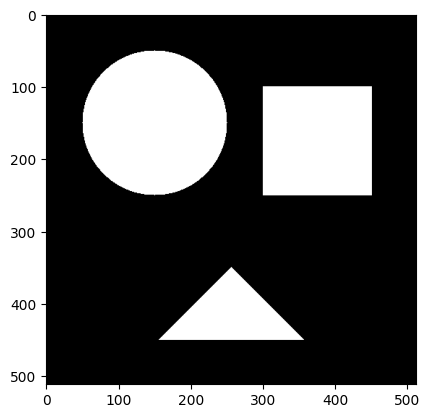

In [ ]:
# Create a black image
image = np.zeros((512, 512), dtype=np.uint8)

# Draw a white circle
cv2.circle(image, (150, 150), 100, 255, -1)

# Draw a white rectangle
cv2.rectangle(image, (300, 100), (450, 250), 255, -1)

# Draw a white triangle
points = np.array([[256, 350], [156, 450], [356, 450]], np.int32)
points = points.reshape((-1, 1, 2))
cv2.fillPoly(image, [points], 255)

# Display the image
plt.imshow(image, cmap='gray')
plt.show()

Number of labels (including background): 4
Unique labels in the image: [0 1 2 3]
Object: 1
  Bounding Box: x=50, y=50, width=201, height=201
  Area: 31417 pixels
  Centroid: (x=150.00, y=150.00)
Object: 2
  Bounding Box: x=300, y=100, width=151, height=151
  Area: 22801 pixels
  Centroid: (x=375.00, y=175.00)
Object: 3
  Bounding Box: x=156, y=350, width=201, height=101
  Area: 10201 pixels
  Centroid: (x=256.00, y=416.83)


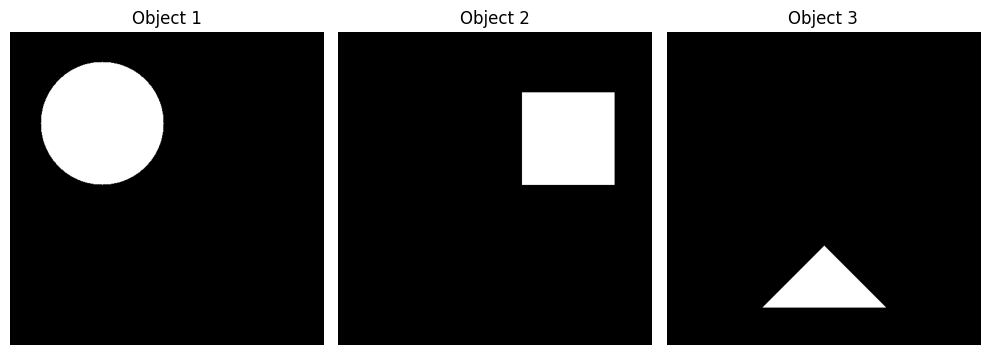

In [ ]:
# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

# Print the number of labels in the image
print(f"Number of labels (including background): {num_labels}")

# Print unique labels
unique_labels = np.unique(labels) # returns the sorted unique elements from the input array
print("Unique labels in the image:", unique_labels)

# Plot each labeled object separately
plt.figure(figsize=(10, 10))
for label in range(1, num_labels):  # starts from 1 to skip the background
    # Create a binary mask for the current label
    mask = np.where(labels == label, 255, 0).astype(np.uint8)
    # for each element in the array 'labels', if the condition (labels == label)
    # is True, it replaces it with 255 (white), and if False, it replaces it
    # with 0 (black) in an image). Then, it converts the resulting array to uint8 format

    # Plot each object in a separate subplot
    plt.subplot(1, num_labels-1, label)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Object {label}')
    plt.axis('off')

    # Print statistics for each object:
    print(f'Object: {label}')
    print(f'  Bounding Box: x={stats[label, 0]}, y={stats[label, 1]}, width={stats[label, 2]}, height={stats[label, 3]}')
    print(f'  Area: {stats[label, 4]} pixels')
    print(f'  Centroid: (x={centroids[label, 0]:.2f}, y={centroids[label, 1]:.2f})')

plt.tight_layout()
plt.show()

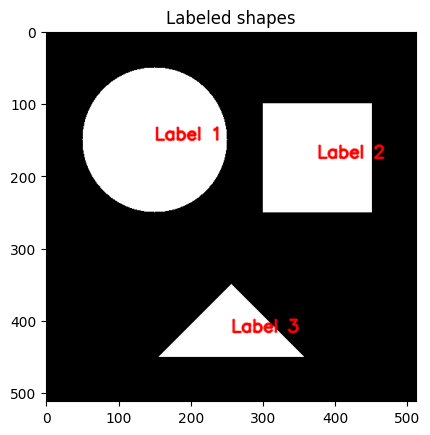

In [ ]:
# Convert the image to RGB to display colored text
image_with_labels = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Annotate each shape with its label
for label in range(1, num_labels):  # starts from 1 to skip the background
    centroid = centroids[label]
    text = f'Label {label}'
    cv2.putText(image_with_labels, text, (int(centroid[0]), int(centroid[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    # Writes the text 'text' in the image, at coordinates (x, y) of the centroid,
    # with a specific font, font scale of 0.8, red color (255, 0, 0),
    # thickness of 2 pixels, and line type defined as anti-aliasing (cv2.LINE_AA)

# Display the image with labels
plt.imshow(image_with_labels)
plt.title('Labeled shapes')
plt.show()

### 1.2. Shape descriptors



Additional parameters that describe the shape of the object can be obtained from OpenCV functions of calculated from area perimeter:

* **Perimeter**: contour length of the shape. It is provided by the function `cv2.arcLength`.

* **Compactness**: is a measure of how compact or circular a shape is. A circle will have the minimum possible value for compactness ($4 \pi$). This is a dimensionless measure.

$$\text{Compactness} = \frac{\text{Perimeter}^2}{\text{Area}}$$

* **Circularity**: it is related to the inverse of compactness. A circle will have a circularity of 1.

$$\text{Circularity} = \frac{4\pi \times \text{Area}}{\text{Perimeter}^2}$$

*	**Aspect ratio**: is the ratio between the width and height of the bounding box that surrounds an object. It measures how stretched or compressed a shape is along the horizontal or vertical axes, but it does not provide information about the internal geometry of the shape.

$$\text{Aspect Ratio} = \frac{\text{Width}}{\text{Height}}$$

* **Extent**: represents how much of the bounding box is filled by the object. It is defined as the ratio of the area of the object to the area of its bounding box, and ranges from 0 (extremely thin or scattered structures) to 1 (solid rectangle or square).

$$\text{Extent} = \frac{\text{Area of the object}}{\text{Area of the bounding box}}$$

* **Eccentricity**: is a measure of how stretched a shape is. It can be computed using the major ($\lambda_1$) and minor ($\lambda_2$) axes of an ellipse fitted to the contour, and is defined in the range $[0, 1]$ (0 for a circle, where $\lambda_1 = \lambda_2$, and 1 for a line, with $\lambda_2 = 0$).

$$\text{Eccentricity} = \sqrt{1 - \left(\dfrac{\lambda_2}{\lambda_1}\right)^2}\quad \text{with }\lambda_1 \geq \lambda_2$$

Label: 1
  Bounding box: x=50, y=50, width=201, height=201
  Centroid: (x=150.00, y=150.00)
  Area: 31417 pixels
  Perimeter: 661.75 pixels
  Compactness: 13.9389147191077
  Circularity: 0.9015314942082957
  Aspect ratio: 1.00
  Extent: 0.78
Label: 2
  Bounding box: x=300, y=100, width=151, height=151
  Centroid: (x=375.00, y=175.00)
  Area: 22801 pixels
  Perimeter: 600.00 pixels
  Compactness: 15.788781193807289
  Circularity: 0.7959050454944542
  Aspect ratio: 1.00
  Extent: 1.00
Label: 3
  Bounding box: x=156, y=350, width=201, height=101
  Centroid: (x=256.00, y=416.83)
  Area: 10201 pixels
  Perimeter: 482.84 pixels
  Compactness: 22.854336331737322
  Circularity: 0.549846227514755
  Aspect ratio: 1.99
  Extent: 0.50


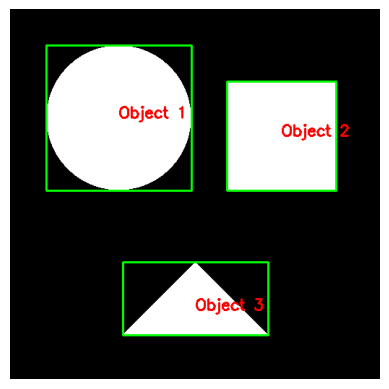

In [ ]:
# Convert the black & white (grayscale) image to color image
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

for label in range(1, num_labels):  # Skip label 0 as it is the background
    # Extracts statistics for each label (x, y, width, height, area)
    x = stats[label, cv2.CC_STAT_LEFT]  # similar to stats[label, 0]
    y = stats[label, cv2.CC_STAT_TOP]  # similar to stats[label, 1]
    width = stats[label, cv2.CC_STAT_WIDTH]    # similar to stats[label, 2]
    height = stats[label, cv2.CC_STAT_HEIGHT]   # similar to stats[label, 3]
    area = stats[label, cv2.CC_STAT_AREA]    # similar to stats[label, 4]
    centroid = centroids[label]  # Centroid of each object

    # Extract the contour for the labeled region
    mask = np.zeros_like(image)
    mask[labels == label] = 255  # creates a boolean mask for each object or label
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the perimeter of the current contour
    perimeter = cv2.arcLength(contours[0], True)

    # Draw the bounding box in green (0, 255, 0) with thickness of 2 pixels
    cv2.rectangle(output_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    # Label the object
    cv2.putText(output_image, f"Object {label}", (int(centroids[label][0]), int(centroids[label][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2) # Red color, thickness = 2

    # Calculate different shape descriptors
    compactness = (perimeter**2) / area if area != 0 else 0  # Compactness
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter != 0 else 0  # Circularity
    aspect_ratio = float(width) / height  # Aspect Ratio
    extent = float(area) / (width * height) # Extent

    print(f'Label: {label}')
    print(f'  Bounding box: x={x}, y={y}, width={width}, height={height}')
    print(f'  Centroid: (x={centroid[0]:.2f}, y={centroid[1]:.2f})')
    print(f'  Area: {area} pixels')
    print(f'  Perimeter: {perimeter:.2f} pixels')
    print(f"  Compactness: {compactness}")
    print(f"  Circularity: {circularity}")
    print(f'  Aspect ratio: {aspect_ratio:.2f}')
    print(f'  Extent: {extent:.2f}')

plt.imshow(output_image)
plt.axis('off')
plt.show()

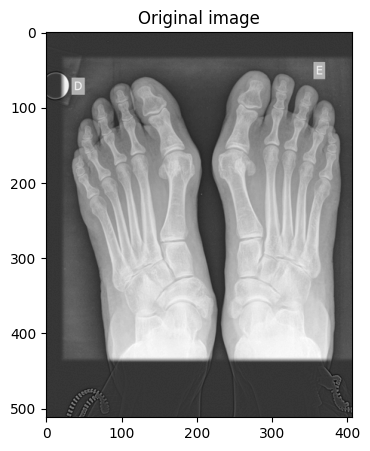

In [ ]:
# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_4.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()

Optimal threshold (Otsu's method): 114.0


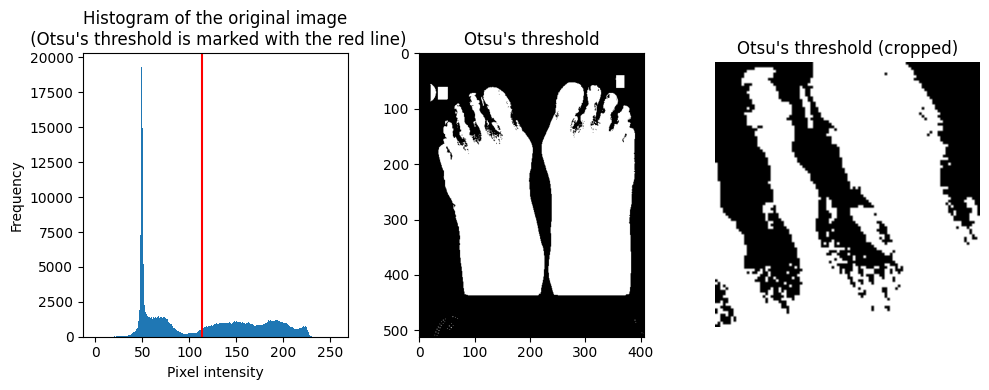

Number of labels (including background): 65


In [ ]:
# Apply Otsu's thresholding
otsu_threshold, otsu_threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Optimal threshold (Otsu's method): {otsu_threshold}")

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.hist(image.flatten(), bins=256, range=[0, 256])
plt.title("Histogram of the original image\n (Otsu's threshold is marked with the red line)")
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.axvline(otsu_threshold, color='r')  # Otsu's threshold

plt.subplot(1, 3, 2)
plt.imshow(otsu_threshold_image, cmap='gray')
plt.title("Otsu's threshold")

plt.subplot(1, 3, 3)
plt.imshow(otsu_threshold_image[70:170, 80:180], cmap='gray')
plt.title("Otsu's threshold (cropped)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(otsu_threshold_image, connectivity=8)
print(f"Number of labels (including background): {num_labels}")

Number of labels (including background): 5


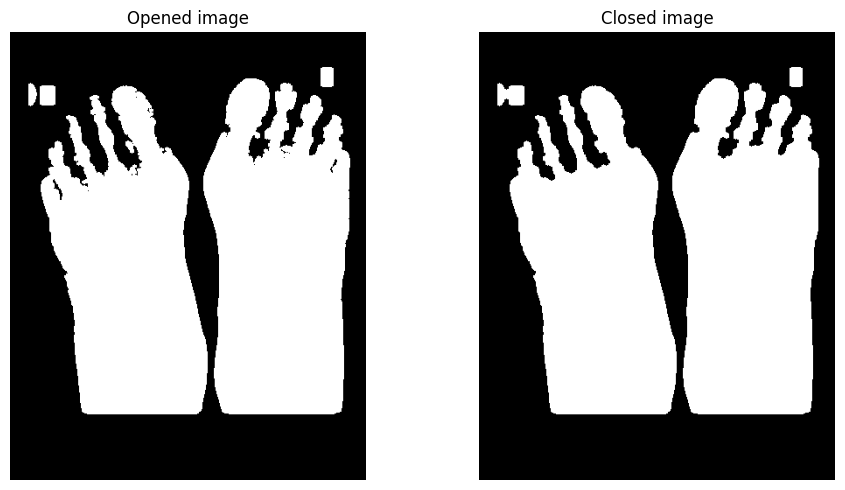

In [ ]:
# Perform opening and closing
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opened_image = cv2.morphologyEx(otsu_threshold_image, cv2.MORPH_OPEN, structuring_element)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, structuring_element)

# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_image, connectivity=8)
print(f"Number of labels (including background): {num_labels}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(opened_image, cmap='gray')
plt.title("Opened image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closed_image, cmap='gray')
plt.title("Closed image")
plt.axis('off')

plt.tight_layout()
plt.show()

Number of labels (including background): 5
Unique labels in the image: [0 1 2 3 4]
Object: 1
  Bounding Box: x=355, y=40, width=15, height=23
  Area: 337 pixels
  Centroid: (x=362.00, y=51.00)
Object: 2
  Bounding Box: x=221, y=53, width=168, height=384
  Area: 51686 pixels
  Centroid: (x=307.20, y=258.32)
Object: 3
  Bounding Box: x=21, y=58, width=31, height=27
  Area: 651 pixels
  Centroid: (x=36.23, y=71.56)
Object: 4
  Bounding Box: x=35, y=61, width=191, height=376
  Area: 47958 pixels
  Centroid: (x=134.66, y=270.90)


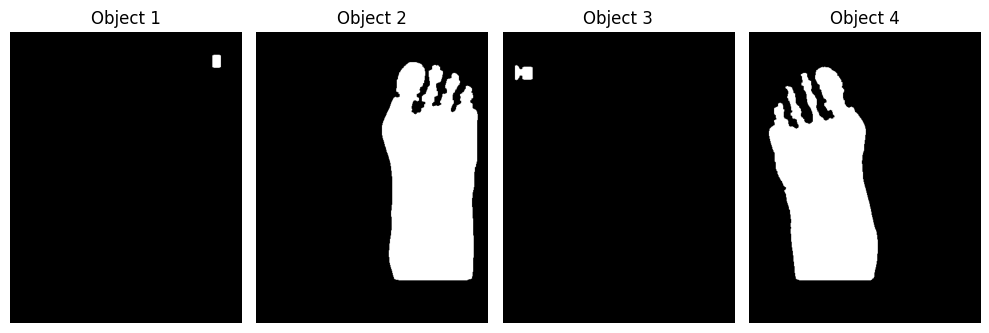

In [ ]:
# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_image, connectivity=8)

# Print the number of labels in the image
print(f"Number of labels (including background): {num_labels}")

# Print unique labels
unique_labels = np.unique(labels) # returns the sorted unique elements from the input array
print("Unique labels in the image:", unique_labels)

# Plot each labeled object separately
plt.figure(figsize=(10, 10))
for label in range(1, num_labels):  # starts from 1 to skip the background
    # Create a binary mask for the current label
    mask = np.where(labels == label, 255, 0).astype(np.uint8)
    # for each element in the array 'labels', if the condition (labels == label)
    # is True, it replaces it with 255 (white), and if False, it replaces it
    # with 0 (black) in an image). Then, it converts the resulting array to uint8 format

    # Plot each object in a separate subplot
    plt.subplot(1, num_labels-1, label)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Object {label}')
    plt.axis('off')

    # Print statistics for each object:
    print(f'Object: {label}')
    print(f'  Bounding Box: x={stats[label, 0]}, y={stats[label, 1]}, width={stats[label, 2]}, height={stats[label, 3]}')
    print(f'  Area: {stats[label, 4]} pixels')
    print(f'  Centroid: (x={centroids[label, 0]:.2f}, y={centroids[label, 1]:.2f})')

plt.tight_layout()
plt.show()

Label: 1
  Bounding box: x=355, y=40, width=15, height=23
  Centroid: (x=362.00, y=51.00)
  Area: 337 pixels
  Perimeter: 69.66 pixels
  Compactness: 14.397855579963368
  Circularity: 0.8727946008742465
  Aspect ratio: 0.65
  Extent: 0.98
Label: 2
  Bounding box: x=221, y=53, width=168, height=384
  Centroid: (x=307.20, y=258.32)
  Area: 51686 pixels
  Perimeter: 1546.36 pixels
  Compactness: 46.2648177698346
  Circularity: 0.27161828836928104
  Aspect ratio: 0.44
  Extent: 0.80
Label: 3
  Bounding box: x=21, y=58, width=31, height=27
  Centroid: (x=36.23, y=71.56)
  Area: 651 pixels
  Perimeter: 125.11 pixels
  Compactness: 24.04483434829081
  Circularity: 0.5226224656961479
  Aspect ratio: 1.15
  Extent: 0.78
Label: 4
  Bounding box: x=35, y=61, width=191, height=376
  Centroid: (x=134.66, y=270.90)
  Area: 47958 pixels
  Perimeter: 1554.77 pixels
  Compactness: 50.40496564398154
  Circularity: 0.24930818727498974
  Aspect ratio: 0.51
  Extent: 0.67


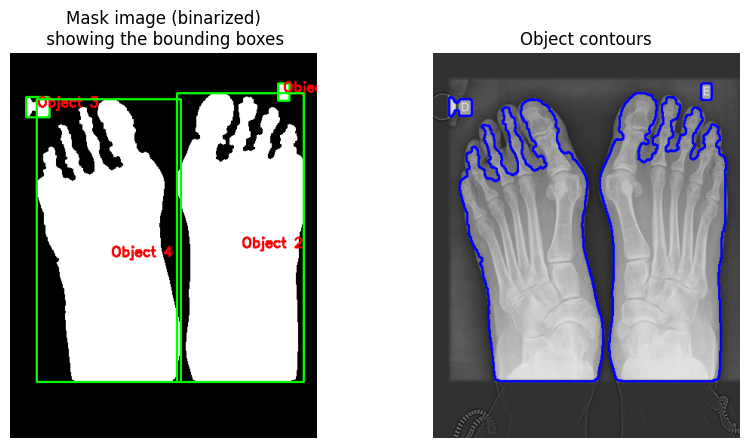

In [ ]:
# Convert the original image to color image
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Convert the black & white image to color image
mask_image = cv2.cvtColor(closed_image, cv2.COLOR_GRAY2RGB)

for label in range(1, num_labels):  # starts from 1 to skip the background
    # Extracts statistics for each label (x, y, width, height, area)
    x = stats[label, cv2.CC_STAT_LEFT]  # similar to stats[label, 0]
    y = stats[label, cv2.CC_STAT_TOP]  # similar to stats[label, 1]
    width = stats[label, cv2.CC_STAT_WIDTH]    # similar to stats[label, 2]
    height = stats[label, cv2.CC_STAT_HEIGHT]   # similar to stats[label, 3]
    area = stats[label, cv2.CC_STAT_AREA]    # similar to stats[label, 4]
    centroid = centroids[label]  # Centroid of each object

    # Extract the contour for the labeled region
    mask = np.uint8(np.zeros_like(image)) # create an empty mask (black image with the same dimensions as the original image)
    mask[labels == label] = 255  # create a boolean mask (in white) for each object or label
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find the contours
    if contours: # if a contour was extracted, then draw it
        cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 2)  # Draw contours in blue

    # Extract the perimeter of the current contour
    perimeter = cv2.arcLength(contours[0], True)

    # Draw the bounding box in green (0, 255, 0) with thickness of 2 pixels
    cv2.rectangle(mask_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    # Label the object
    cv2.putText(mask_image, f"Object {label}", (int(centroids[label][0]), int(centroids[label][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2) # Red color, thickness = 2

    # Calculate different shape descriptors
    compactness = (perimeter**2) / area if area != 0 else 0  # Compactness
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter != 0 else 0  # Circularity
    aspect_ratio = float(width) / height  # Aspect Ratio
    extent = float(area) / (width * height) # Extent

    print(f'Label: {label}')
    print(f'  Bounding box: x={x}, y={y}, width={width}, height={height}')
    print(f'  Centroid: (x={centroid[0]:.2f}, y={centroid[1]:.2f})')
    print(f'  Area: {area} pixels')
    print(f'  Perimeter: {perimeter:.2f} pixels')
    print(f"  Compactness: {compactness}")
    print(f"  Circularity: {circularity}")
    print(f'  Aspect ratio: {aspect_ratio:.2f}')
    print(f'  Extent: {extent:.2f}')

plt.figure(figsize=(10, 5))

# Mask image (binarized)
plt.subplot(1, 2, 1)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask image (binarized)\n showing the bounding boxes')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(contour_image)
plt.title("Object contours")
plt.axis('off')

plt.show()

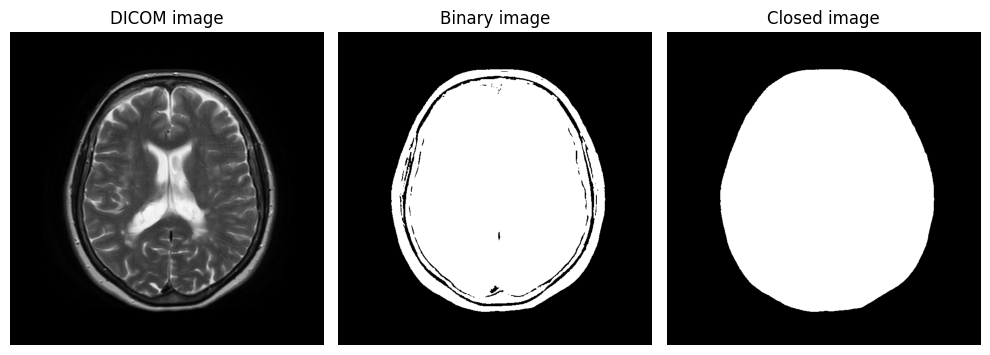

Number of labels (including background): 2
Unique labels in the image: [0 1]
Label: 1
  Bounding box: x=114, y=82, width=458, height=519
  Centroid: (x=342.47, y=344.00)
  Area: 188599 pixels
  Perimeter: 1643.68 pixels
  Compactness: 14.324935578380689
  Circularity: 0.877237495805876
  Aspect ratio: 0.88
  Extent: 0.79


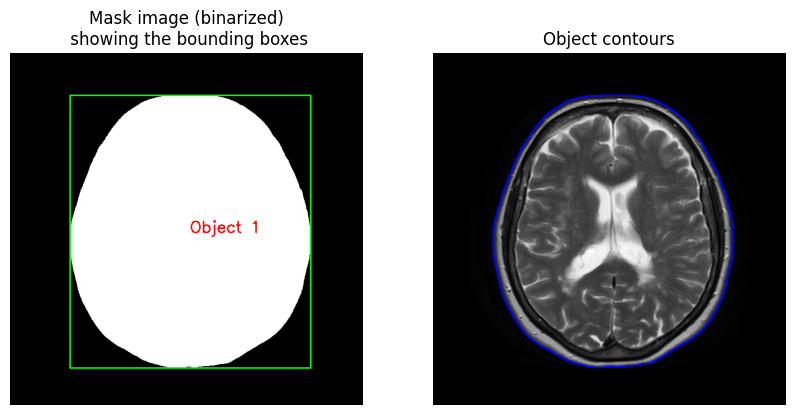

Pixel spacing:  [0.34226191043853, 0.34226191043853]
Image width (pixels):  672
Image height (pixels):  672
Image width (mm):  230.00000381469215
Image height (mm):  230.00000381469215
Head width (pixels):  458
Head height (pixels):  519
Head width (mm):  156.75595498084672
Head height (mm):  177.63393151759706


In [ ]:
# Open the DICOM file
dicom_file = pydicom.dcmread('/content/drive/MyDrive/PIM/Images/IM000015.dcm')
image = dicom_file.pixel_array

# Normalize the image to the uint8 range (0,255)
image_norm = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Binarize the image using a threshold
threshold = 20
_, binary_image = cv2.threshold(image_norm, threshold, 255, cv2.THRESH_BINARY)

# Perform closing
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
closed_image = np.uint8(cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, structuring_element))

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_norm, cmap='gray')
plt.title("DICOM image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title("Binary image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closed_image, cmap='gray')
plt.title("Closed image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_image, connectivity=8)

# Print the number of labels in the image
print(f"Number of labels (including background): {num_labels}")

# Print unique labels
unique_labels = np.unique(labels) # returns the sorted unique elements from the input array
print("Unique labels in the image:", unique_labels)

# Convert the original image to color image
contour_image = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2RGB)

# Convert the black & white image to color image
mask_image = cv2.cvtColor(closed_image, cv2.COLOR_GRAY2RGB)

for label in range(1, num_labels):  # starts from 1 to skip the background
    # Extracts statistics for each label (x, y, width, height, area)
    x = stats[label, cv2.CC_STAT_LEFT]  # similar to stats[label, 0]
    y = stats[label, cv2.CC_STAT_TOP]  # similar to stats[label, 1]
    width = stats[label, cv2.CC_STAT_WIDTH]    # similar to stats[label, 2]
    height = stats[label, cv2.CC_STAT_HEIGHT]   # similar to stats[label, 3]
    area = stats[label, cv2.CC_STAT_AREA]    # similar to stats[label, 4]
    centroid = centroids[label]  # Centroid of each object

    # Extract the contour for the labeled region
    mask = np.uint8(np.zeros_like(image_norm)) # create an empty mask (black image with the same dimensions as the original image)
    mask[labels == label] = 255  # create a boolean mask (in white) for each object or label
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find the contours
    if contours: # if a contour was extracted, then draw it
        cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 2)  # Draw contours in blue

    # Extract the perimeter of the current contour
    perimeter = cv2.arcLength(contours[0], True)

    # Draw the bounding box in green (0, 255, 0) with thickness of 2 pixels
    cv2.rectangle(mask_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    # Label the object
    cv2.putText(mask_image, f"Object {label}", (int(centroids[label][0]), int(centroids[label][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2) # Red color, thickness = 2

    # Calculate different shape descriptors
    compactness = (perimeter**2) / area if area != 0 else 0  # Compactness
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter != 0 else 0  # Circularity
    aspect_ratio = float(width) / height  # Aspect Ratio
    extent = float(area) / (width * height) # Extent

    print(f'Label: {label}')
    print(f'  Bounding box: x={x}, y={y}, width={width}, height={height}')
    print(f'  Centroid: (x={centroid[0]:.2f}, y={centroid[1]:.2f})')
    print(f'  Area: {area} pixels')
    print(f'  Perimeter: {perimeter:.2f} pixels')
    print(f"  Compactness: {compactness}")
    print(f"  Circularity: {circularity}")
    print(f'  Aspect ratio: {aspect_ratio:.2f}')
    print(f'  Extent: {extent:.2f}')

plt.figure(figsize=(10, 5))

# Mask image (binarized)
plt.subplot(1, 2, 1)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask image (binarized)\n showing the bounding boxes')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(contour_image)
plt.title("Object contours")
plt.axis('off')

plt.show()


## Calculate real dimensions

# Access the Pixel Spacing attribute
pixel_spacing = dicom_file.PixelSpacing
print("Pixel spacing: ", pixel_spacing)

# Image dimensions in pixels
image_width_pixels = dicom_file.Columns
image_height_pixels = dicom_file.Rows

print("Image width (pixels): ", image_width_pixels)
print("Image height (pixels): ", image_height_pixels)

# Calculate real dimensions of the image
image_width_mm = image_width_pixels * pixel_spacing[0]
image_height_mm = image_height_pixels * pixel_spacing[1]

print("Image width (mm): ", image_width_mm)
print("Image height (mm): ", image_height_mm)

# Width and heigth of the head section in pixels
head_width_pixels = stats[label, cv2.CC_STAT_WIDTH]
head_height_pixels = stats[label, cv2.CC_STAT_HEIGHT]

print("Head width (pixels): ", head_width_pixels)
print("Head height (pixels): ", head_height_pixels)

# Calculate real dimensions of the head section (width, heigth)
head_width_mm = head_width_pixels * pixel_spacing[0]
head_height_mm = head_height_pixels * pixel_spacing[1]

print("Head width (mm): ", head_width_mm)
print("Head height (mm): ", head_height_mm)

## 2.- Corner Detection

Corner detection in an image is a common task once the image has been segmented and a set of objects have been delimited.

Its applications in medical image range from tracking organ boundaries using the corners as a landmark points, to cell and nucleus detection in histopathological images.

### 2.1. Harris Corner Detection


The Harris corner detection method identifies points in an image where the **intensity changes significantly in multiple directions**.

This method is an improved version of the **Moravec's method** for corner detection, which, in turn, can be considered as an extension of the Sobel filter for edge detection to 2D dimensions: detecting changes in intensity as the detection window is shifted along each of the four main directions (horizontal, diagonal, and the two diagonals).

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*wFF0E8ysDtcTpR5q.png" alt="Caption" width="600">
<p style="text-align: center;">Figure 1: Corner detection: flat region (left), edge (center), and corner (right). Source: <a href="https://medium.com/@itberrios6/harris-corner-and-edge-detector-4169312aa2f8#f9f0">Medium.com.</a></p>

Harris' method identifies corners by **evaluating the eigenvalues of the autocorrelation matrix**. This matrix captures the intensity changes in an image by analyzing the gradient (derivatives) in both x and y directions.

The **eigenvalues** of this matrix provide insight into the directional intensity changes:

*	If **both eigenvalues** are **large**, the point has **strong** intensity changes in **both directions**, indicating a **corner**.
*	If **one eigenvalue** is **large** and the other is **small**, it indicates an **edge**.
*	If **both eigenvalues** are **small**, it indicates a **flat region** with no significant features.

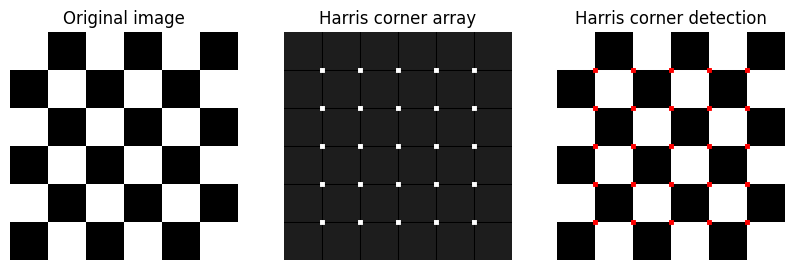

In [ ]:
# Define the size of the checkerboard
board_size = 6  # 6x6 checkerboard
square_size = 40  # Size of each square in pixels

# Create the checkerboard pattern
image = np.zeros((board_size * square_size, board_size * square_size), dtype=np.uint8)

# Fill the checkerboard with alternating black and white squares
for i in range(board_size):
  for j in range(board_size):
    if (i + j) % 2 == 0:
      image[i*square_size:(i+1)*square_size, j*square_size:(j+1)*square_size] = 255  # White square
    else:
      image[i*square_size:(i+1)*square_size, j*square_size:(j+1)*square_size] = 0  # Black square

# Apply Harris corner detection
# - image: grayscale image
# - blockSize=2: size of the neighborhood (in pixels) considered around each pixel
#   to compute the gradient covariance matrix (lower values seek for finer details)
# - ksize=3: aperture parameter for the Sobel filter used internally to compute
#   image gradients
# - k=0.04: sensitivity constant that affects the response to corners, typically
#   in the range between 0.04 and 0.06 (lower values make the algorithm more
#   sensitive to edges, while higher values focus more on strong corners)
# - harris_corners: image where higher values represent likely corner points
#   (usually, a threshold is required to extract the actual corner locations)
harris_corners = cv2.cornerHarris(image, blockSize=2, ksize=3, k=0.04)

# Result is dilated to mark the corners
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
harris_corners = cv2.dilate(harris_corners, kernel, iterations=1)

# Create a copy of the image to mark the corners
image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Threshold to mark the corners in the image using a Boolean mask (10% of the maximum value)
image_with_corners[harris_corners > 0.1 * harris_corners.max()] = [255, 0, 0]


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(harris_corners, cmap='gray')
plt.title('Harris corner array')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_with_corners)
plt.title('Harris corner detection')
plt.axis('off')

plt.show()

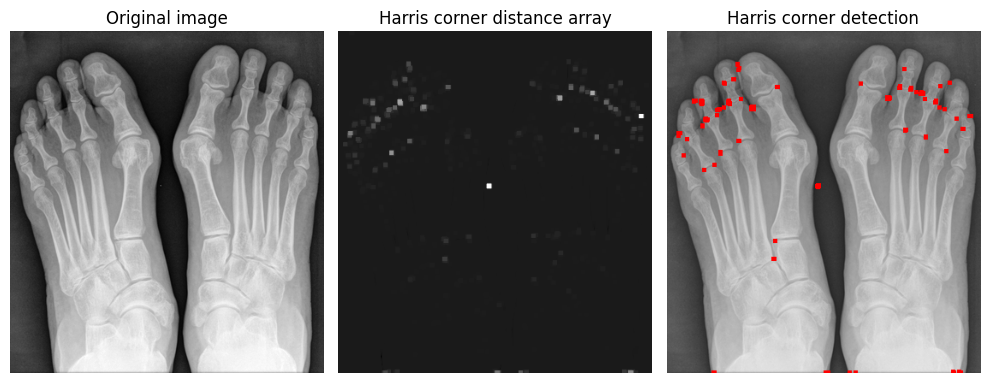

In [ ]:
# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_4_mod.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Harris corner detection
dst = cv2.cornerHarris(image, blockSize=2, ksize=3, k=0.04)

# Result is dilated to mark the corners
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dst = cv2.dilate(dst, kernel, iterations=2)

# Create a copy of the image to mark the corners
image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Threshold to mark the corners in the image using a Boolean mask
image_with_corners[dst > 0.1 * dst.max()] = [255, 0, 0]


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dst, cmap='gray')
plt.title('Harris corner distance array')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_with_corners)
plt.title('Harris corner detection')
plt.axis('off')

plt.tight_layout()
plt.show()

## 3.- Keypoints Detection

Keypoint detection is used to **identify distinctive and stable points in an image**, which can be reliably detected under various conditions such as changes in scale, rotation, and illumination **across different images** of the same scene or object.

### 3.1. Scale-Invariant Feature Transform (SIFT)


The Scale-Invariant Feature Transform (SIFT)[1] is an algorithm for **extracting keypoints from an image**, extending the concept of corner detection to achieve **scale and rotational invariance**.

SIFT focuses on **finding stable points** within an image that are **invariant to changes** in viewpoint, such as **rotation, scaling, and translation**.

These points are assigned **unique identifiers**, enabling the **recognition of specific features across different images**, even if those features have undergone transformations, like object deformation or they appear in different frames of a video.

The keypoints identified by SIFT must satisfy two **conditions**: they need to be **stable** (the same keypoint is identified regardless of how the image is transformed), and easily **distinguishable** (it has characteristics like its local image gradients that make it stand out compared to other keypoints).

In addition to the keypoints, the algorithm assigns each keypoint a **unique descriptor** that encapsulates information about its **surrounding neighborhood** (capturing details like gradients, intensity patterns, and orientation), making it identifiable in subsequent images.

[1]: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf


The SIFT algorithm consists of the following stages:

1. **Scale-space extrema detection at different scales**:

  * SIFT begins by detecting keypoints across multiple scales using a method based on the Difference of Gaussians (**DoG**).
  
    This technique approximates the Laplacian of Gaussian (**LoG**) by subtracting one Gaussian-smoothed image from another with a different smoothing factor (sigma).
    
    The resulting images **highlight areas of rapid intensity change**, which correspond to **edges and corners** in the image.
    
    The algorithm constructs a **scale-space pyramid** by progressively **blurring** the image with increasing Gaussian kernels and then **downsampling** (octaves).

    <img src="https://docs.opencv.org/4.x/sift_dog.jpg" alt="Caption" width="600"><p style="text-align: center;">Figure 2: Difference of Gaussians (DoG) at different scales to approximate the Laplacian of Gaussian (LoG) filter for edge detection. Source: <a href="https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html">OpenCV.</a></p>

  *	The DoG is calculated at each level of this pyramid, and allow SIFT to become **scale-invariant**. The goal is to find **local maxima** in the DoG images, which are **stable across scales** (**keypoints**).
  
    These keypoints are more likely to be stable under various transformations. Every pixel in an image is **compared** with its 8 neighbors and 9+9 neighbors in the previous and next scales to find out if it is a **local maximum or minimum**.
    
    Those points that are local extrema are considered **potential keypoints**. After that, only the **strong** interest points remain and the rest (low-contrast keypoints and edges) are **eliminated**.

  <img src="https://docs.opencv.org/4.x/sift_local_extrema.jpg" alt="Caption" width="400"><p style="text-align: center;">Figure 3: Local extrema detection over scale and space. Source: <a href="https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html">OpenCV.</a></p>

2. **Orientation assignment**:

  * For each detected keypoint, the algorithm calculates the **gradient magnitude and direction in a neighborhood around the keypoint**. Rather than assigning a single orientation to the keypoint, SIFT calculates a **histogram of gradients** within this region.

  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*LYpnMuXsYxxBu9apbpsC6g.png" alt="Caption" width="600"><p style="text-align: center;">Figure 4: Orientations in the neighborhood of a pixel and dominant orientation. Source: <a href="https://medium.com/jun94-devpblog/cv-13-scale-invariant-local-feature-extraction-3-sift-315b5de72d48">Medium.com.</a></p>

  * The **peak** of this histogram represents the **dominant orientation of the keypoint**. Assigning this orientation helps establish a reference point to achieve **rotation invariance**.

3. **Generation of the descriptor**:

  * Once the keypoints are detected and oriented, the algorithm generates a **descriptor** for each keypoint (128-dimensional vector).
  
    This descriptor captures the **local gradient distribution** within the region around the keypoint, and is designed to be **robust** to changes in illumination and minor distortions, making it a **reliable identifier** for matching keypoints across images.

  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*WCFIwODh3BFOMbnbUtnFZw.png" alt="Caption" width="500"><p style="text-align: center;">Figure 5: Local keypoint descriptor of SIFT. Source: <a href="https://medium.com/jun94-devpblog/cv-13-scale-invariant-local-feature-extraction-3-sift-315b5de72d48">Medium.com.</a></p>

  * SIFT achieves **rotation invariance** by rotating the region around each keypoint so that its dominant orientation points upwards. This ensures that all local descriptors share the **same orientation**, enabling accurate, rotation-invariant **comparisons** during descriptor matching.

  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*qhHkVsPO4vC51YPSqqBfWw.png" alt="Caption" width="500"><p style="text-align: center;">Figure 6: Rotation of the region around the keypoint to achieve rotation invariance. Source: <a href="https://medium.com/jun94-devpblog/cv-13-scale-invariant-local-feature-extraction-3-sift-315b5de72d48">Medium.com.</a></p>

4. **Keypoint matching**:

  * After generating the descriptors, SIFT **matches keypoints** across different images by comparing their **descriptors** and measuring their **similarity**.

  <img src="https://www.researchgate.net/publication/378905328/figure/fig6/AS:11431281229647961@1710559903633/Example-of-matching-results-a-matching-by-SIFT-b-matching-by-MAR.png" alt="Caption" width="500"><p style="text-align: center;">Figure 7: Matching points in SIFT algorithm (top) and in Mean-based Adaptive RANSAC algorithm (bottom). Source: <a href="https://www.researchgate.net/figure/Example-of-matching-results-a-matching-by-SIFT-b-matching-by-MAR_fig6_378905328">ResearchGate.</a></p>

#### **Applications of SIFT to Image Registration**

**Image Registration** [2] involves **aligning two or more images** of the same scene or object so that they can be **compared or analyzed together**.

It finds application in medical contexts, where images might be taken at **different times and/or conditions**: SIFT can be applied in these cases to **align images taken at different times** (before and after a treatment), **from different angles or viewpoints**, or **using different sensors or imaging modalities** (CT and MRI).

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*GV0hPlNs6lmVpRxcD2DfEg.jpeg" alt="Caption" width="700"><p style="text-align: center;">Figure 8: Process of image registration using SIFT. Source: <a href="https://medium.com/sicara/image-registration-sift-deep-learning-3c794d794b7a">Medium.com.</a></p>

By identifying and matching the key features in the images, **SIFT enables accurate alignment**, and allows tasks such as disease monitoring, multi-modal image fusion, and image-guided surgery.

Image registration can be **classified** based on several criteria:

1. Intra- and Intermodal registration:

  * **Intramodal registration** refers to aligning images from the same modality (e.g., CT-to-CT) to assess changes over time, such as tumor growth or organ movement.

  * **Intermodal registration or multi-modal fusion** refers to aligning images from different modalities (e.g., CT-to-MRI, or T1-to-T2 MRI) to combine complementary information provided by each modality.

  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*fQ1JFS4yWLea8Q3PaFym9g.png" alt="Caption" width="500"><p style="text-align: center;">Figure 9: Multi-modal rigid image registration between head axial CT (pink) and MRI (green) images: before image registration (left) and after (right). Source: <a href="https://medium.com/sicara/image-registration-sift-deep-learning-3c794d794b7a">Medium.com.</a></p>

2. Rigid and non-rigid registration:

  * **Rigid registration** aligns images using only translation and rotation, keeping the shape and size of the structures unchanged. It is used for images where no significant deformation is expected, such as brain images.

  * **Non-rigid (or deformable) registration** allows for more complex transformations, including stretching and bending, for registering soft tissues or organs that may change shape, such as the heart or lungs during breathing.

  <img src="https://www.cartcas.polimi.it/wp-content/uploads/2019/12/Validation_SIFT.png" alt="Caption" width="500"><p style="text-align: center;">Figure 10: Non-rigid registration during the respiratory phases. Source: <a href="https://www.cartcas.polimi.it/index.html%3Fp=291.html">Medium.com.</a></p>


[2]: https://medium.com/sicara/image-registration-sift-deep-learning-3c794d794b7a





#### **Implementation of SIFT in OpenCV**

In OpenCV, the computation of the SIFT algorithm is implemented using two functions:

* `sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)`: creates a SIFT object and allow to specify various parameters that affect how **keypoints** are detected and how **descriptors** are computed. This function has the following **parameters**:

  * `nfeatures (int, default: 0)`: specifies the maximum number of keypoints to detect. If set to 0, the algorithm detects as many keypoints as possible based on the image content.
  * `nOctaveLayers (int, default: 3)`: defines the number of layers per octave in the Gaussian pyramid. Increasing this value may result in detecting more keypoints, but it also increases the computational cost.
  * `contrastThreshold (float, default: 0.04)`: controls the minimum contrast required to consider a keypoint valid. Keypoints with lower contrast than this threshold are discarded, allowing to filter out weak keypoints.
  * `edgeThreshold (float, default: 10)`: controls the algorithm's sensitivity to edge-like structures. Lower values make the algorithm more sensitive to edges, while higher values focus more on corners.
  * `sigma (float, default: 1.6)`: defines the sigma of the Gaussian blur applied to the input image at each octave to create the Gaussian pyramid. This value controls how much smoothing is applied to the image before detecting keypoints. Higher values are used to detect larger features, while lower sigmas are better for smaller features.


* `keypoints, descriptors = sift.detectAndCompute(image, None)`: **detect keypoints and compute descriptors** for these keypoints. The method returns these values.

Once the keypoints and descriptors have been computed, three additional functions are used to represent these keypoints and match them across images:

* `image_with_keypoints = cv2.drawKeypoints(image, keypoints, output_image, color, flags)`: is used to **draw keypoints** detected by SIFT (and other similar algorithms, such as SURF, or ORB) on an image. Keypoints are **marked** with circles or other shapes at their locations, and **additional visual information** can be provided to help understand the keypoints' scale and orientation. It has the following parameters:

  * `image`: input image (grayscale or color) on which the keypoints will be drawn.
  * `keypoints`: list of keypoints detected in the image (from `detectAndCompute()`).
  * `output_image`: output image where the keypoints will be drawn. If set to `None`, a new image will be created based on the input image.
  * `color`: specifies the color of the keypoints in BGR format or `None`for random colors.
  * `flags`: controls how keypoints are drawn. The flag `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` draws circles representing the size and orientation of the keypoints.

* `bf = cv2.BFMatcher(normType, crossCheck=False)`: BFMatcher stands for Brute Force Matcher, and it is used to **match feature descriptors between two images**. It works by comparing each descriptor in the first set with every descriptor in the second set using a distance metric. It selects the **closest matching descriptor** based on the smallest distance. This function returns the created object `bf`.

  * `normType`: is the distance metric used to compare the descriptors. Common values are `cv2.NORM_L2`(Euclidean distance) and `cv2.NORM_HAMMING` (Hamming distance, used in binary descriptors).

  * `crossCheck` (optional, default is False): if set to True, it will perform cross-checking, meaning that a match is retained only if the two keypoints are each other's best matches. This can result in fewer but more accurate matches.

* `matches = bf.match(descriptors1, descriptors2`: this method **compares the descriptors** from both images and **returns a list of objects**, where each object contains **information about a match between descriptors** from the two images.

* `result_image = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, outImg, flags=0)`: once the descriptors are matched, this function allows to **visualize the matches by drawing lines between corresponding keypoints** in two images:

	* `img1` and `img2`: first and second input images to be compared.
	*	`keypoints1` and `keypoints2`: keypoints detected in the first and second images.
	* `matches`: matches between the two images.
	* `outImg`: output image (if `None` then the function will create a new image).
	*	`flags` (optional): controls the drawing behavior (default is 0).

Rotation and scaling transformation matrix: 
[[  0.49497475   0.49497475   2.01010127]
 [ -0.49497475   0.49497475 200.        ]]

Transformation matrix including translation: 
[[  0.49497475   0.49497475  52.01010127]
 [ -0.49497475   0.49497475 250.        ]]

Length of keypoints in image 1:  19
Shape of descriptors in image 1:  (19, 128)

Length of keypoints in image 2:  7
Shape of descriptors in image 2:  (7, 128)

Coordinates of keypoints in image 1:
(147.56, 232.75)
(150.02, 120.86)
(150.02, 120.86)
(150.25, 56.89)
(150.25, 56.89)
(150.26, 54.18)
(150.26, 54.18)
(150.32, 113.86)
(150.32, 113.86)
(150.41, 81.62)
(150.41, 81.62)
(212.49, 274.47)
(217.93, 139.41)
(243.07, 295.38)
(243.07, 295.38)
(275.23, 80.91)
(275.23, 80.91)
(275.87, 171.13)
(275.87, 171.13)

Coordinates of keypoints in image 2:
(153.49, 202.99)
(153.49, 202.99)
(185.68, 235.23)
(185.68, 235.23)
(230.69, 212.45)
(240.32, 292.40)
(274.06, 199.33)


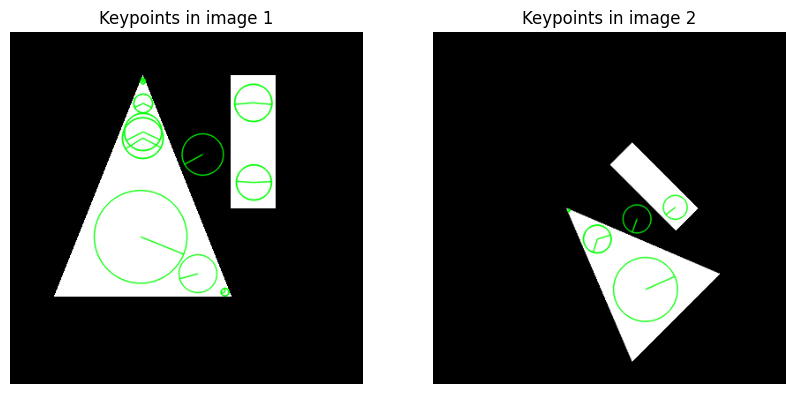

Number of matches:  7


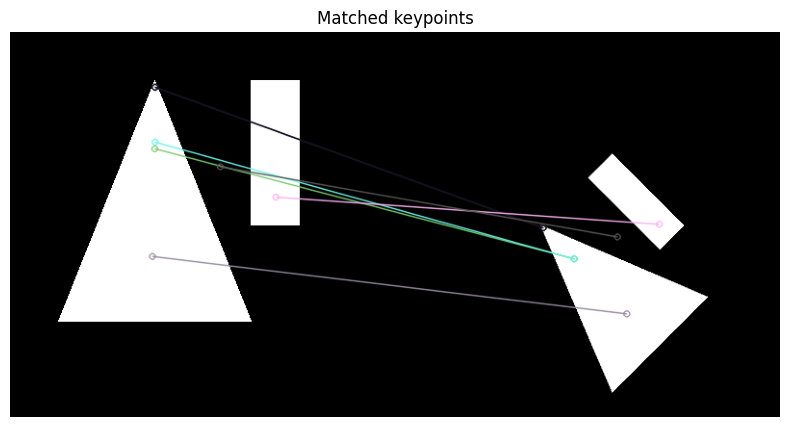

In [ ]:
## Creates a synthetic image (image1) and a affine-transformed version (image2)

# Create a black image
image1 = np.zeros((400, 400), dtype=np.uint8)

# Draw a white triangle
points_triangle = np.array([[150, 50], [50, 300], [250, 300]]) # define 3 points
cv2.drawContours(image1, [points_triangle], 0, (255), -1) # draw a triangle

# Draw a white square
points_square = np.array([[250, 50], [250, 200], [300, 200], [300, 50]])
cv2.drawContours(image1, [points_square], 0, (255), -1)

# Apply rotation, translation, and scaling to create a second image
M = cv2.getRotationMatrix2D((200, 200), 45, 0.7)  # Rotate around the center, scale by 0.7
print("Rotation and scaling transformation matrix: ")
print(M)
M[:, 2] += 50  # Translate the image (M[0, 2] += 50 (tx), M[1, 2] += 50 (ty))
print("\nTransformation matrix including translation: ")
print(M)
image2 = cv2.warpAffine(image1, M, (400, 400))


## Apply the SIFT algorithm

# 1. Initialize SIFT detector
sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.3, edgeThreshold=10)

# 2. Detect keypoints and descriptors with SIFT
# 'None' to detect keypoints in the entire image; otherwise, use a Boolean mask (255/0)
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

print("\nLength of keypoints in image 1: ", len(keypoints1))
print("Shape of descriptors in image 1: ", descriptors1.shape)
print("\nLength of keypoints in image 2: ", len(keypoints2))
print("Shape of descriptors in image 2: ", descriptors2.shape)

# Print the identified keypoints
print("\nCoordinates of keypoints in image 1:")
for kp in keypoints1:
    print(f"({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")

print("\nCoordinates of keypoints in image 2:")
for kp in keypoints2:
    print(f"({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")

# 3. Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the images with keypoints
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1_keypoints, cmap='gray')
plt.title("Keypoints in image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_keypoints, cmap='gray')
plt.title("Keypoints in image 2")
plt.axis('off')

plt.show()

# 4a. Use the Brute-Force Matcher to match keypoints based on their descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# 4b. Sort the matches based on their distances (lower distance is better)
def get_distance(match): # this function receives an object, 'match', which have a property called 'distance'
    return match.distance # accesses and returns the 'distance' attribute of the 'match' object

# sorts the 'matches' list using the sorted function
# sorted() returns a new sorted list and leaves the original list unchanged
# key=get_distance indicates the sorted() function to use the get_distance function to extract
#   the value to sort by (in this case, the distance attribute)
matches = sorted(matches, key=get_distance)
print("Number of matches: ", len(matches))

# 5. Draw the matched keypoints between the two images
# Plotting of the best matches (ordered by distance)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:7], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot the matched keypoints
plt.figure(figsize=(10, 5))
plt.imshow(matched_image)
plt.title("Matched keypoints")
plt.axis('off')
plt.show()


Length of keypoints in image 1:  43
Shape of descriptors in image 1:  (43, 128)

Length of keypoints in image 2:  16
Shape of descriptors in image 2:  (16, 128)


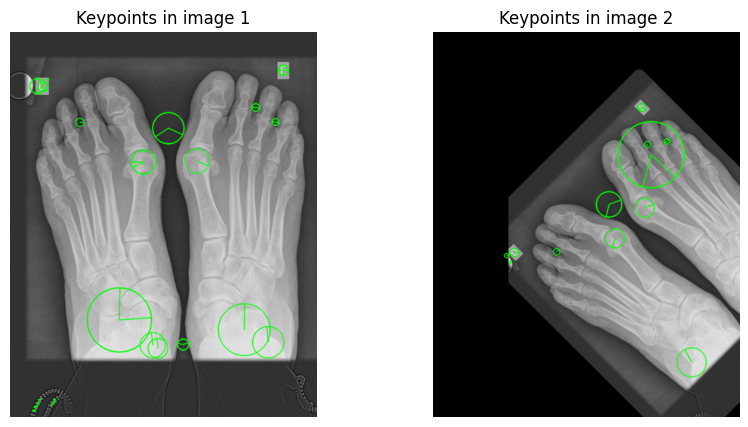

Number of matches:  13


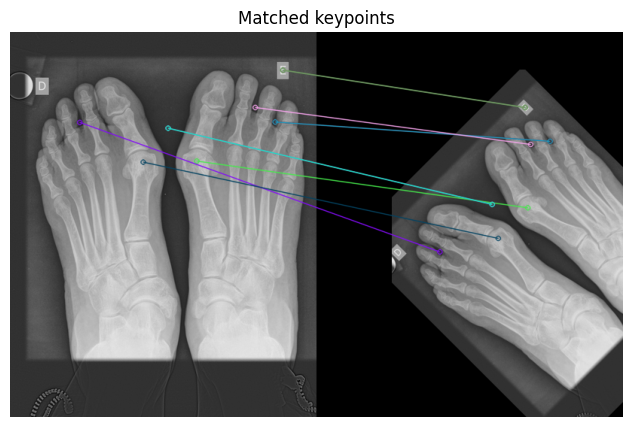

In [ ]:
# Load the grayscale image
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_4.png'
image1 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to apply rotation, scaling, and translation
def transform_image(image, angle, scale, tx, ty):
    # Get image dimensions
    rows, cols = image.shape

    # Compute the center of the image
    center = (cols // 2, rows // 2)

    # Create the transformation matrix for rotation and scaling
    M_rotation = cv2.getRotationMatrix2D(center, angle, scale)

    # Apply the rotation and scaling
    rotated_scaled_image = cv2.warpAffine(image, M_rotation, (cols, rows))

    # Create the translation matrix
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])

    # Apply the translation
    transformed_image = cv2.warpAffine(rotated_scaled_image, M_translation, (cols, rows))

    return transformed_image

# Selectable parameters for transformation
angle = 45  # Rotation angle in degrees
scale = 0.8  # Scaling factor
tx, ty = 100, 50  # Translation along the x and y axes

# Apply the transformation
image2 = transform_image(image1, angle, scale, tx, ty)


## Apply the SIFT algorithm

# 1. Initialize SIFT detector
sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.1, edgeThreshold=10)

# 2. Detect keypoints and descriptors with SIFT
# 'None' to detect keypoints in the entire image; otherwise, use a Boolean mask (255/0)
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

print("\nLength of keypoints in image 1: ", len(keypoints1))
print("Shape of descriptors in image 1: ", descriptors1.shape)
print("\nLength of keypoints in image 2: ", len(keypoints2))
print("Shape of descriptors in image 2: ", descriptors2.shape)

# Print the identified keypoints
#print("\nCoordinates of keypoints in image 1:")
#for kp in keypoints1:
#    print(f"({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")

#print("\nCoordinates of keypoints in image 2:")
#for kp in keypoints2:
#    print(f"({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")

# 3. Draw keypoints on the images
image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the images with keypoints
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1_keypoints, cmap='gray')
plt.title("Keypoints in image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_keypoints, cmap='gray')
plt.title("Keypoints in image 2")
plt.axis('off')

plt.show()

# 4a. Use the Brute-Force Matcher to match keypoints based on their descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# 4b. Sort the matches based on their distances (lower distance is better)
def get_distance(match): # this function receives an object, 'match', which have a property called 'distance'
    return match.distance # accesses and returns the 'distance' attribute of the 'match' object

# sorts the 'matches' list using the sorted function
# sorted() returns a new sorted list and leaves the original list unchanged
# key=get_distance indicates the sorted() function to use the get_distance function to extract
#   the value to sort by (in this case, the distance attribute)
matches = sorted(matches, key=get_distance)
print("Number of matches: ", len(matches))

# 5. Draw the matched keypoints between the two images
# Plotting of the best matches (ordered by distance)
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot the matched keypoints
plt.figure(figsize=(10, 5))
plt.imshow(matched_image)
plt.title("Matched keypoints")
plt.axis('off')
plt.show()

## 4.- Shape Detection


Shape detection techniques are used in image processing to **identify and analyze specific structures or patterns within an image**, such as vessels, blobs, or other anatomical structures.

### 4.1. Frangi Filter

The Frangi filter is specifically designed to **enhance tubular structures such as blood vessels, nerves and other elongated anatomical features** in medical images.

Its primary goal is to **improve the visibility and segmentation** of these structures in MRI, CT and angiography images.

This filter operates over **multiple scales**, allowing it to **detect structures of varying sizes**. By analyzing the image at different scales, the Frangi filter can **capture both small and large** tubular features.

The Frangi filter is based on the eigenvalues of the Hessian matrix, and includes several **parameters** that **control its sensitivity** to various features.

Its **applications in medical imaging** includes angiography (enhances the visualization of blood vessels), retinal imaging (detection of retinal blood vessels), neuroscience (neural fibers and vascular structures in brain imaging), pulmonary imaging (bronchial tree in lung CT scans), and liver imaging (bile ducts and hepatic vessels).


The **function** used is `frangi()` from `skimage.filters`:

    skimage.filters.frangi(image, scale_range=(1, 10), scale_step=2, alpha=0.5, beta=0.5, gamma=15, black_ridges=True)


It has several **parameters** that allow to tune the filter's sensitivity to structures of different scales, shapes, and noise levels for **vessel detection**:


* `image`: input image in float format and scaled to [0, 1],
* `scale_range`: tuple specifying the range of scales (in pixel size) for which the filter will look for vessels,
* `scale_step` (default: 2): step size between consecutive scales in the scale_range,
* `alpha` (range: 0 < `alpha` ≤ 1, default: 0.5): controls the sensitivity to the vesselness response; a higher alpha increases the emphasis on long, tubular structures,
* `beta` (range: 0 < `beta` ≤ 1, default: 0.5): controls the filter's sensitivity to blob-like structures; a smaller value makes the filter more selective for vessels (line-like structures), whereas a larger value allows it to detect blobs,
* `gamma` (default: 15): controls the filter's sensitivity to noise; a higher value of gamma reduces the effect of noise, whereas a lower value makes the filter more sensitive to small variations (which could include noise),
* `black_ridges` (default: True): if True, the filter assumes that the vessels (ridges) are darker than the background, and vice versa.

Minimum and maximum values of the Frangi image: 0.0, 5.129141572979279e-05


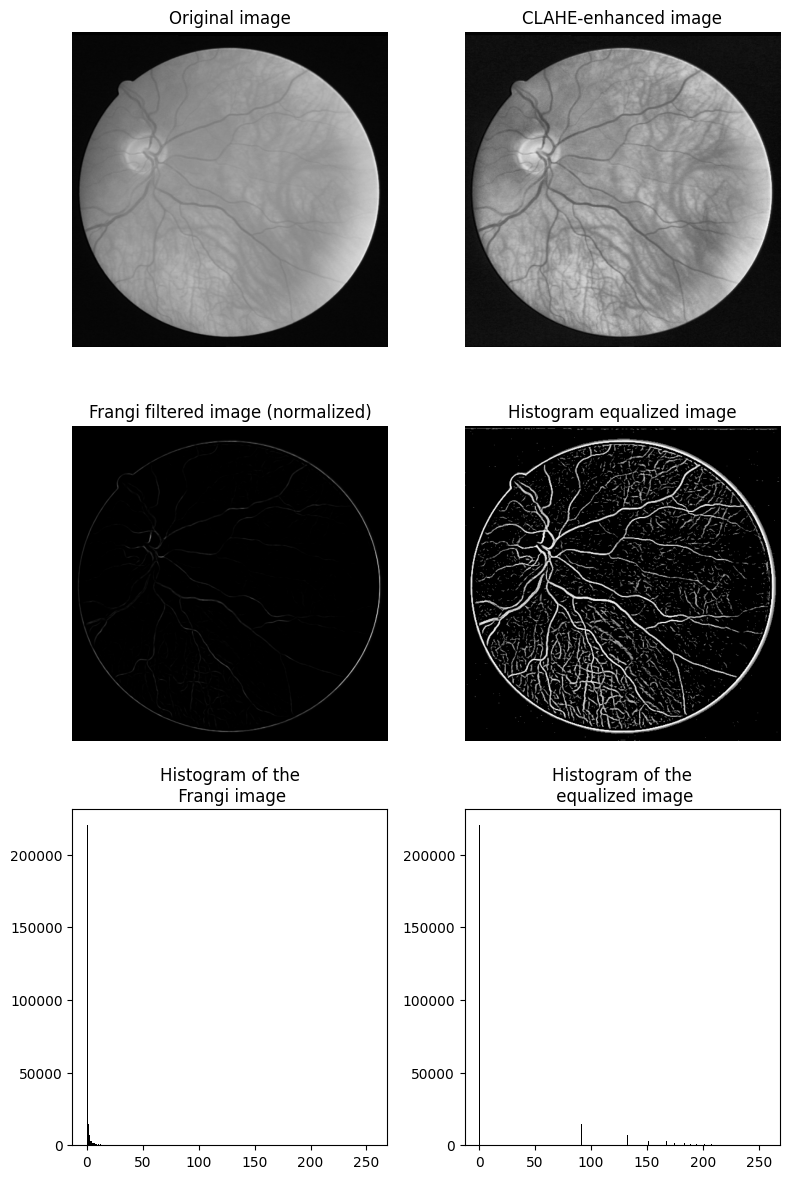

In [ ]:
from skimage.filters import frangi

# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/Retina_blood_vessel_9.png'
#image_path = '/content/drive/MyDrive/PIM/Images/Cerebral_Angiogram_Lateral_Wikipedia.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_float = np.float32(image)

# Apply CLAHE algorithm
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(image)

# Convert the CLAHE image to float and normalize it to the range [0, 1]
clahe_image_float = cv2.normalize(clahe_image.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Apply the Frangi filter
frangi_filtered = frangi(clahe_image_float, gamma=15, black_ridges=True)
print(f"Minimum and maximum values of the Frangi image: {np.min(frangi_filtered)}, {np.max(frangi_filtered)}")

# Scale the Frangi output back to [0, 255] and convert it to uint8
scaled_frangi = cv2.normalize(frangi_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Apply histogram equalization
equalized_frangi = cv2.equalizeHist(scaled_frangi)


plt.figure(figsize=(8, 12))

# Display the original image
plt.subplot(3, 2, 1)
plt.title("Original image")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# Display the CLAHE-enhanced image
plt.subplot(3, 2, 2)
plt.title("CLAHE-enhanced image")
plt.imshow(clahe_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# Display the normalized Frangi filtered image
plt.subplot(3, 2, 3)
plt.title("Frangi filtered image (normalized)")
plt.imshow(scaled_frangi, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# Display the histogram-equalized Frangi filtered image
plt.subplot(3, 2, 4)
plt.title(f"Histogram equalized image")
plt.imshow(equalized_frangi, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# Display the histogram of the Frangi filtered image
plt.subplot(3, 2, 5)
plt.hist(scaled_frangi.flatten(), bins=256, range=[0, 256], color='black')
plt.title(f'Histogram of the\n Frangi image')

# Display the histogram of the equalized image
plt.subplot(3, 2, 6)
plt.hist(equalized_frangi.flatten(), bins=256, range=[0, 256], color='black')
plt.title(f'Histogram of the\n equalized image')

plt.tight_layout()
plt.show()

## References

* González, Rafael C., _Digital image processing: Chapter 11 (Feature Extraction)_. Prentice Hall,. 2018. 9780132345637

* Chityala, Ravishankar, _Image Processing and Acquisition Using Python: Chapter 10 (Image Measurements)_. Chapman and Hall/CRC, 2022. 9780367531577

* Toennies, Klaus D., _Guide to Medical Image Analysis - Methods and Algorithms: Chapters 5 (Feature Detection), 10 (Registration and Normalization), and 11 (Shape, Appearance and Spatial Relationships)_. Springer, 2017. 9781447174035

* Birkfellner, Wolfgang, _Applied Medical Image Processing - A Basic Course: Chapter 9 (Registration)_. CRC Press, 2014. 9781466555570


